In [1]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# __CNN trained on MNIS__ Federated Learning - _testing different dataset partitions_

### IID split

In [6]:
# Cell 2: Define the model class (must match your training code)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))



In [7]:
# Cell 3: Load the MNIST test set (as 3-channel images)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



In [20]:
# Cell 4: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_iid_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


C:\Users\francesco\AppData\Local\Temp\ipykernel_10700\941415922.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [21]:
# Cell 5: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")


Accuracy on MNIST test set: 99.21%


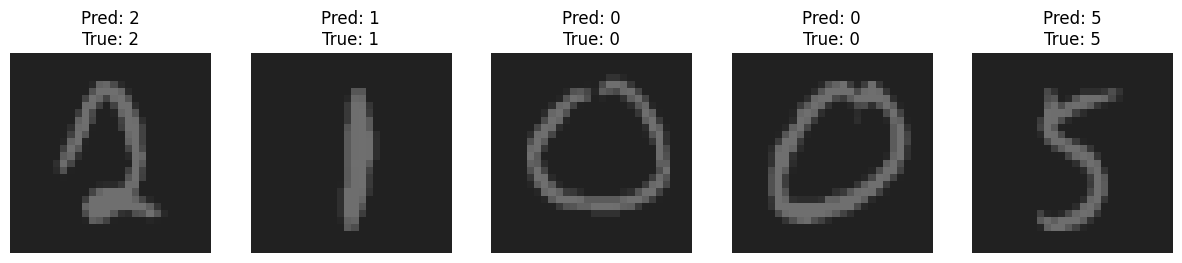

In [33]:
# Cell 6: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.5

In [23]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha05_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_10700\2553426214.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [24]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")


Accuracy on MNIST test set: 98.82%


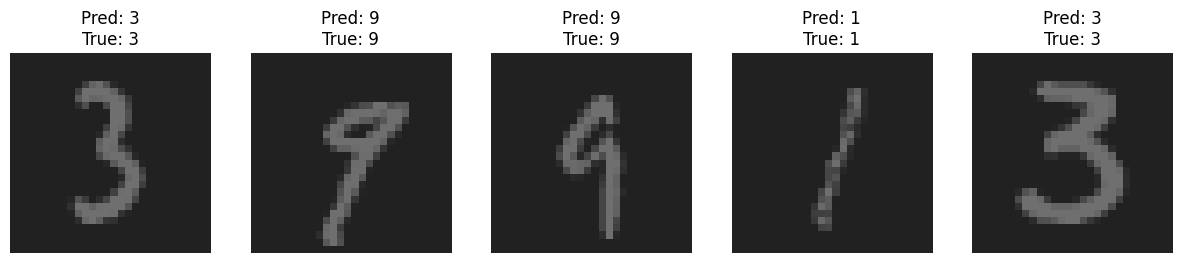

In [25]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.2

In [29]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha02_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_10700\3958925051.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [30]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 97.41%


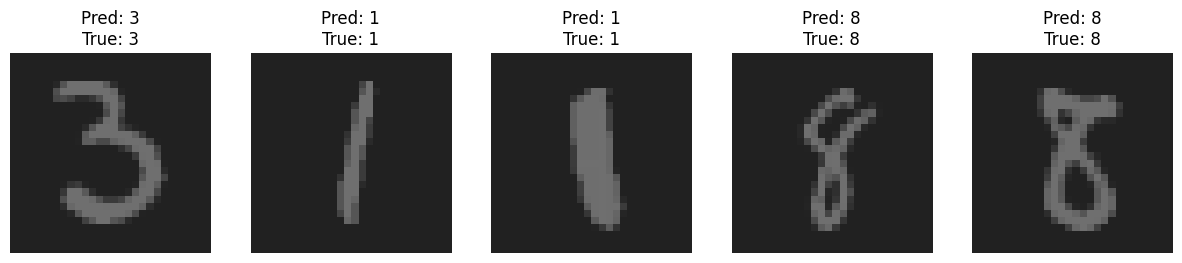

In [31]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.05

In [34]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha005_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_10700\2063368363.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [35]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 95.16%


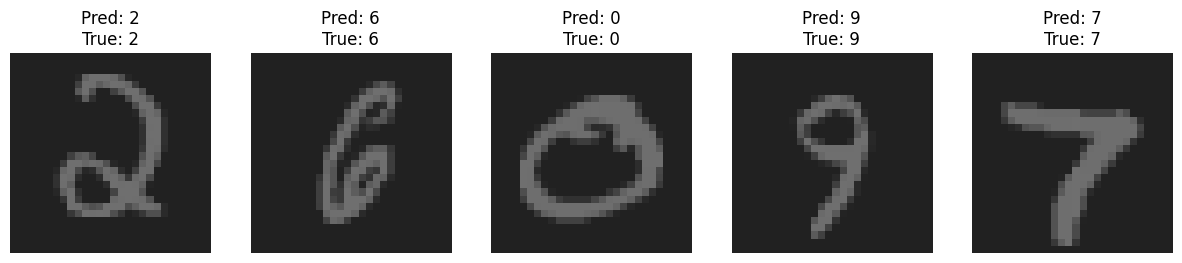

In [36]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()